In [1]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [3]:
# Configurations
plt.style.use('dark_background')

class StarCluster:
    def __init__(self, n_stars=2000):
        """
        Initialize a star cluster with n_stars.
        We use the 'Salpeter IMF' (Initial Mass Function): 
        Most stars are small, few are massive.
        """

        # Generate masses from 0.1 to 10 Solar Masses using a power law
        # Probability P(M) ~ M^-2.35
        self.masses = np.random.uniform(0.1, 100, n_stars)**(-2.35 + 1) # Simplified Inverse Transform
        
        # Filter to reasonable range (0.1 to 10 Solar Masses)
        self.masses = self.masses[(self.masses > 0.1) & (self.masses < 10)]
        self.n_stars = len(self.masses)
        
        # Calculate Main Sequence Properties (Zero Age)
        # L ~ M^3.5 (Solar Units)
        self.luminosity_ms = self.masses ** 3.5
        # T ~ M^0.55 (Solar Units, approx)
        self.temp_ms = self.masses ** 0.55
        
        # Lifetime: t ~ M^-2.5 (in Solar Lifetimes ~ 10 Billion Years)
        self.lifetimes = self.masses ** (-2.5) * 1e10  # Years


    def evolve(self, age_years):
        """
        Returns the current L and T for all stars at a specific age.
        """
        current_L = self.luminosity_ms.copy()
        current_T = self.temp_ms.copy()
        status = np.array(['Main Sequence'] * self.n_stars)
        
        # Identify Dead/Evolved Stars
        # If Age > Lifetime, the star leaves the Main Sequence
        is_evolved = age_years > self.lifetimes
        
        # A simple model for "Red Giant Branch":
        # When they die, they get Brighter (L * 50) and Cooler (T * 0.5)
        # (This is a simplified approximation for visualization!)
        current_L[is_evolved] *= 50
        current_T[is_evolved] *= 0.5
        status[is_evolved] = 'Red Giant'
        
        # Identify White Dwarfs / Supernovae (The really old ones)
        # Let's say if Age > 1.2 * Lifetime, they shed layers and become White Dwarfs
        is_dead = age_years > 1.2 * self.lifetimes
        current_L[is_dead] = 1e-3 # Dim
        current_T[is_dead] = 3.0  # Hot (White Dwarf)
        status[is_dead] = 'White Dwarf'
        
        return current_T, current_L, status

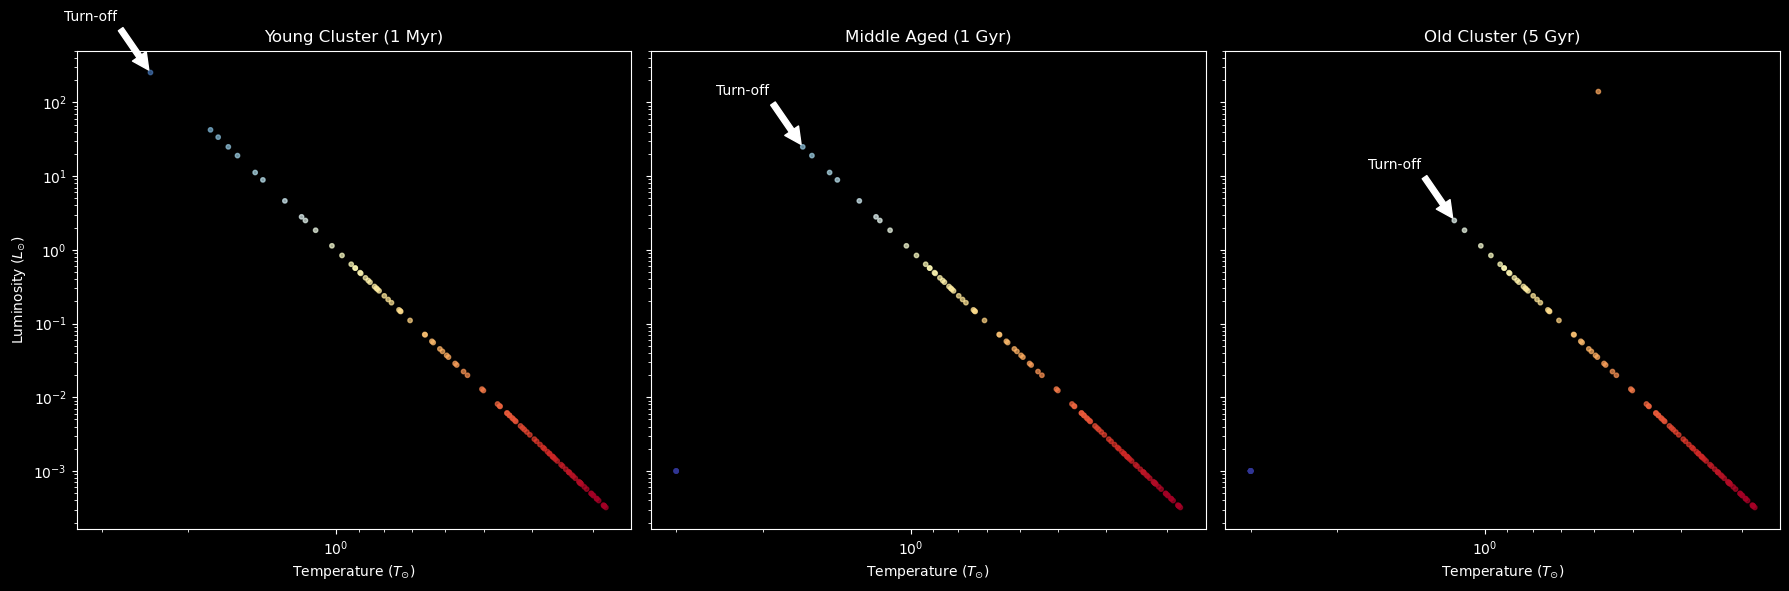

In [4]:
# 1. Simulate
cluster = StarCluster(n_stars = 2000)

# Let's look at the cluster at 3 different ages
ages = [1e6, 1e9, 5e9] # 1 Million, 1 Billion, 5 Billion Years
titles = ["Young Cluster (1 Myr)", "Middle Aged (1 Gyr)", "Old Cluster (5 Gyr)"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True, sharex=True)

for ax, age, title in zip(axes, ages, titles):
    T, L, status = cluster.evolve(age)
    
    # We plot log-log because scales are huge
    # Color logic: Map Temperature to Color (Blue=Hot, Red=Cool)
    # We normalize T roughly: Sun=1.0 (Yellow). High=Blue. Low=Red.
    norm = mcolors.LogNorm(vmin=0.3, vmax=3.0)
    
    # Scatter plot
    sc = ax.scatter(T, L, c=T, cmap='RdYlBu', s=10, alpha=0.7, norm=norm)
    
    # Formatting the H-R Diagram
    ax.set_title(title)
    ax.set_xlabel(r"Temperature ($T_{\odot}$)")
    if ax == axes[0]:
        ax.set_ylabel(r"Luminosity ($L_{\odot}$)")
        
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.invert_xaxis() # H-R Diagrams always have Hot (Left) to Cool (Right)
    
    # Mark the "Turn-off Point"
    # Identify the heaviest star that is still on Main Sequence
    ms_mask = status == 'Main Sequence'
    if np.any(ms_mask):
        max_mass_on_ms = np.max(cluster.masses[ms_mask])
        turn_off_T = max_mass_on_ms**0.55
        turn_off_L = max_mass_on_ms**3.5
        ax.annotate('Turn-off', xy=(turn_off_T, turn_off_L), xytext=(turn_off_T*1.5, turn_off_L*5),
                    arrowprops=dict(facecolor='white', shrink=0.05))

plt.tight_layout()
plt.show()

In [5]:
# 2. Adding some automated age dating

def estimate_cluster_age(cluster_instance, current_L, current_T, status):
    """
    Analyzes a cluster snapshot to estimate its age based on the Turn-off Point.
    """
    # 1. Identify stars still on the Main Sequence
    ms_mask = status == 'Main Sequence'
    
    if not np.any(ms_mask):
        return "Cluster is dead (All stars evolved)"
    
    # 2. Find the heaviest star remaining on the Main Sequence
    # (In our model, higher Mass = Higher Luminosity)
    # We find the max Luminosity on the MS
    max_L_on_ms = np.max(current_L[ms_mask])
    
    # 3. Convert Luminosity back to Mass
    # Physics: L ~ M^3.5  -->  M ~ L^(1/3.5)
    turn_off_mass = max_L_on_ms ** (1/3.5)
    
    # 4. Calculate Age from Mass
    # Physics: t ~ M^-2.5 * 10^10 years
    estimated_age = (turn_off_mass ** -2.5) * 1e10
    
    return estimated_age, turn_off_mass

In [7]:
# 3. Test the Estimator

# Let's pick a random age, simulate it, and see if the code can guess it.
true_age = 2.5e9  # 2.5 Billion Years
print(f"- Blind Test -")
print(f"True Age: {true_age/1e9} Billion Years")

# 1. Generate the snapshot
T_snap, L_snap, status_snap = cluster.evolve(true_age)

# 2. Ask the estimator to guess
guessed_age, mass_limit = estimate_cluster_age(cluster, L_snap, T_snap, status_snap)

# 3. Report
print(f"Turn-off Mass detected: {mass_limit:.2f} Solar Masses")
print(f"Estimated Age: {guessed_age/1e9:.2f} Billion Years")

error_percent = abs(guessed_age - true_age) / true_age * 100
print(f"Accuracy Error: {error_percent:.2f}%")

- Blind Test -
True Age: 2.5 Billion Years
Turn-off Mass detected: 1.55 Solar Masses
Estimated Age: 3.36 Billion Years
Accuracy Error: 34.27%


In [8]:
# 4. Visualizations (animation)

import matplotlib.animation as animation
from IPython.display import HTML

# Configuration 
# Ensure the class is instantiated (if not already)
if 'cluster' not in locals():
    cluster = StarCluster(n_stars=2000)

# Define Time Steps (Logarithmic spacing to capture fast early changes and slow late changes)
# From 1 Million years (1e6) to 12 Billion years (1.2e10)
num_frames = 100
ages_to_animate = np.geomspace(1e6, 1.2e10, num_frames)

# Setup the Canvas 
fig, ax = plt.subplots(figsize=(8, 8))
plt.style.use('dark_background')

# Set fixed axis limits for the H-R Diagram
ax.set_xlim(3.5, 0.2)  # Temp (inverted: Hot left, Cool right)
ax.set_ylim(1e-4, 1e6) # Luminosity
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r"Temperature ($T_{\odot}$)", fontsize=12)
ax.set_ylabel(r"Luminosity ($L_{\odot}$)", fontsize=12)
ax.grid(True, alpha=0.2)

# Initial Data (Time = 0)
T_init, L_init, _ = cluster.evolve(0)
norm = mcolors.LogNorm(vmin=0.3, vmax=3.0) # Color normalization

# Create the initial scatter plot object
scat = ax.scatter(T_init, L_init, c=T_init, cmap='RdYlBu', s=15, alpha=0.8, norm=norm)
time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, color='white', fontsize=14)

# The Animation Loop 
def update(frame_idx):
    # 1. Get the current age
    current_age = ages_to_animate[frame_idx]
    
    # 2. Evolve the cluster physics
    T_new, L_new, status_new = cluster.evolve(current_age)
    
    # 3. Update the scatter plot data
    # stack T and L together for set_offsets
    data = np.stack([T_new, L_new]).T 
    scat.set_offsets(data)
    
    # 4. Update the colors (based on new Temperatures)
    scat.set_array(T_new)
    
    # 5. Update the timestamp title
    if current_age < 1e9:
        age_str = f"Age: {current_age/1e6:.0f} Million Years"
    else:
        age_str = f"Age: {current_age/1e9:.2f} Billion Years"
    time_text.set_text(age_str)
    
    return scat, time_text

#  Render the Animation 
print("Rendering animation... please wait.")
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)

# Save as GIF (Requires Pillow, which is standard)
gif_path = 'stellar_evolution_hrd.gif'
ani.save(gif_path, writer='pillow', fps=20)
print(f"Animation saved to: {gif_path}")

# To display in notebook (optional, might be slow in some browsers)
# HTML(ani.to_jshtml())
plt.close(fig) # Prevent static plot from showing

Rendering animation... please wait.
Animation saved to: stellar_evolution_hrd.gif


In [10]:
# 5. AI/Data Science Layer: Predicting the Age of the Universe
# 5.1. Import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [12]:
# 5.2. Generate the "Synthetic Universe" (Training Data)

# We need a lot of examples for the AI to learn.
print("Generating training data (simulating 1000 clusters)...")

X = [] # Features (What the AI sees)
y = [] # Targets (The true age)

# Create one cluster instance to reuse (faster)
training_cluster = StarCluster(n_stars=1000)

for _ in range(1000):
    # A. Pick a random age between 10 Myr and 10 Gyr
    random_age = np.random.uniform(1e7, 1e10)
    
    # B. Evolve the cluster
    T, L, status = training_cluster.evolve(random_age)
    
    # C. Extract Features (Summary Statistics)
    # The AI doesn't look at the whole plot (too many pixels). 
    # It looks for "Fingerprints" of age.
    
    # Feature 1: The Temperature of the hottest star still alive
    # (As the cluster ages, the hot blue stars die, so this max_T drops)
    max_T = np.max(T)
    
    # Feature 2: The Luminosity of the brightest star
    max_L = np.max(L)
    
    # Feature 3: The "Color" of the cluster (Mean Temperature of top 10% brightest)
    brightest_indices = np.argsort(L)[-50:]
    mean_T_brightest = np.mean(T[brightest_indices])
    
    X.append([max_T, max_L, mean_T_brightest])
    y.append(random_age)

X = np.array(X)
y = np.array(y)

Generating training data (simulating 1000 clusters)...


In [13]:
# 5.3. Train the Model
# Split into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest (An ensemble of Decision Trees)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [16]:
# 5.4. Evaluate

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance ")
print(f"R² Score: {r2:.4f} (1.0 is perfect)")
print("The AI successfully learned to date star clusters!")


Model Performance 
R² Score: 0.9663 (1.0 is perfect)
The AI successfully learned to date star clusters!


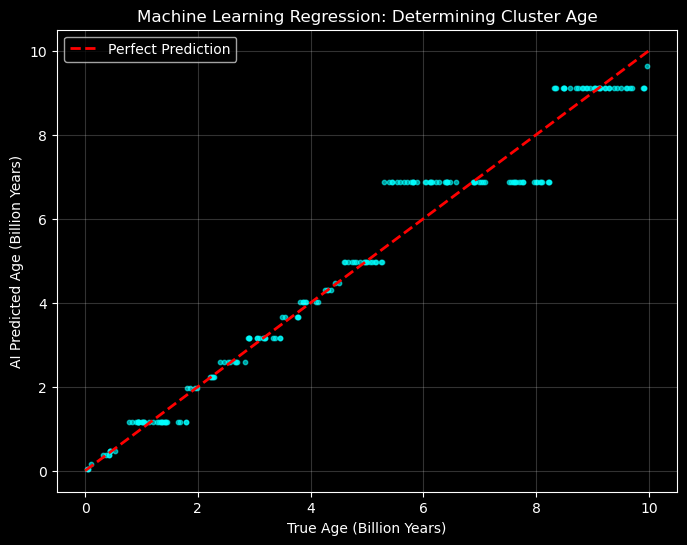

In [17]:
# 5.5 Visualization: Predicted vs True Age
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test/1e9, y_pred/1e9, color='cyan', s=10, alpha=0.6)
ax.plot([0, 10], [0, 10], 'r--', lw=2, label='Perfect Prediction')

ax.set_xlabel("True Age (Billion Years)")
ax.set_ylabel("AI Predicted Age (Billion Years)")
ax.set_title("Machine Learning Regression: Determining Cluster Age")
ax.legend()
ax.grid(True, alpha=0.2)
plt.show() 

In [18]:
# 5.6. Feature Importance (What did the AI actually look at?)
import pandas as pd
importance = pd.Series(model.feature_importances_, index=['Max Temp', 'Max Lum', 'Mean Temp (Bright)'])
print("\nWhat matters most to the AI?")
print(importance.sort_values(ascending=False))


What matters most to the AI?
Mean Temp (Bright)    0.965131
Max Lum               0.034804
Max Temp              0.000064
dtype: float64
